In [1]:
import os
import glob
import sys
sys.path.append('../../activedrops')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from ipywidgets import interact, FloatSlider
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter
import colorcet as cc
import holoviews as hv
import panel as pn
pn.extension()


import autocorrelation
import pivdrops
import viz
viz.set_plotting_style()

# Analysis of ActiveDROPS PIV data

ActiveDROPS imaging is carried out in two channels corresponding to microtubules (Cy5) and fluorescent beads (YFP). For PIV analysis we take only the beads channel and process the images (stored in .tiff files) with Matlab PIVlab. We choose an interrogation window of 128 pixels (~175.34 um), and step sizes of 64 and 32 pixels (87.67 um and 43.84 um, respectively). This means we will have a grid of 128 x 128 velocity vectors pointing the direction of the flow. The imaging interval varies across samples, but for this first example we took one frame every three seconds.

In this notebook we show the pipeline used to analyze ActiveDROPS data. PIVlab produces a .txt file per frame, which contains our grid of vectors with velocity data, as well as other features like divergence, vorticity, etc. We first need code that takes our .txt file and gives us pandas dataframe to work with.

In [2]:
link = "../../data/k401bio-250nM-piv/PIVlab_0001.txt"
files = sorted(glob.glob(link))

df = pd.read_csv(files[0], skiprows=2).fillna(0)
df

,x [m],y [m],u [m/s],v [m/s],Vector type [-],vorticity [1/s],magnitude [m/s],divergence [1/s],dcev [1],simple shear [1/s],simple strain [1/s],vector direction [degrees]
0,0.000023,0.000023,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000023,0.000045,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000023,0.000067,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000023,0.000089,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000023,0.000111,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16124,0.002785,0.002697,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16125,0.002785,0.002719,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16126,0.002785,0.002741,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16127,0.002785,0.002763,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, from this table we already have a lot of features we can visualize. For example, the velocity magnitude of each component.

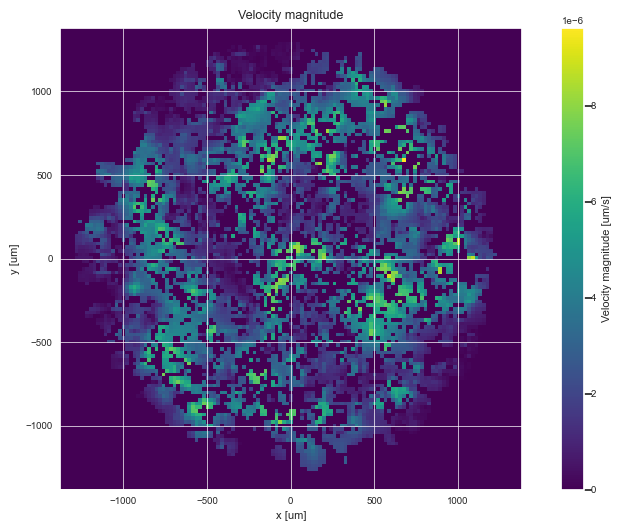

In [3]:
v = df.pivot(index='y [m]', columns='x [m]', values='magnitude [m/s]').values

# Plot the magnitude of the velocity
plt.figure(figsize=(10, 6))  # Set the figure size
im = plt.imshow(v, cmap='viridis', origin='lower', extent=[-2762/2, 2762/2, -2762/2, 2762/2])
plt.xlabel('x [um]')
plt.ylabel('y [um]')
cbar = plt.colorbar(im)
cbar.set_label('Velocity magnitude [um/s]')
plt.title('Velocity magnitude')
plt.show()


## Spatial autocorrelation

Before moving forward with plotting more features, we need to know the relevant scales of the flow, which we can later use to calculate the measured energy of the system over time. Let's calculate the spatial autocorrelation of the velocity data to illustrate the lengths at which vectors are correlated. To do so, we need to follow a few steps.

First we need to apply a Fourier Transform to the velocity magnitude of our data, so we convert it from the spatial to the frequency domain. What does that mean? Let's illustrate it with an example:

The Fourier transform is a mathematical operation that transforms a time-domain signal into its frequency-domain representation. The formula includes the term $e^{-i \omega t}$ (where $i$ is the imaginary unit, $ \omega $ is the angular frequency, and $ t $ is time) because it represents a complex exponential function which can be used to model sinusoids.

The use of $ e^{-i \omega t} $ comes from Euler's formula, which states that:

$$
e^{i\theta} = \cos(\theta) + i\sin(\theta)
$$

From which we can derive Euler's identity when the angle is half a circunference ($\pi$):

$$
e^{i\pi} = -1
$$

Euler's formula says that spinning a point around a circle in the complex plane is like a combination of sliding back and forth along two perpendicular lines, one for cosine in the real plane and one for sine in the imaginary plane.

In [4]:
# Function to plot Euler's formula with a variable radius
def plot_euler(theta, radius):
    # Calculate the point on the circle
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    
    # Set up the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Draw the unit circle scaled by the radius
    circle = plt.Circle((0, 0), radius, fill=True, alpha=0.2)
    ax.add_artist(circle)
    
    # Plot the real and imaginary parts
    ax.plot([0, x], [0, y], 'r')
    ax.plot(x, y, 'ro')
    
    # Annotations
    complex_number = f'{x:.2f} + {y:.2f}i'
    ax.annotate(complex_number, xy=(x, y), xytext=(x+0.1, y),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    # Fixed limits for the plot
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    
    # Grid, legend, and titles
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    plt.title("Visualization of Euler's Formula")
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    plt.show()

# Create the sliders
theta_slider = FloatSlider(min=0, max=2*np.pi, step=0.01, value=np.pi, description='Theta')
radius_slider = FloatSlider(min=0.1, max=2, step=0.1, value=1, description='Radius')

# Show the interactive plot
interact(plot_euler, theta=theta_slider, radius=radius_slider);


interactive(children=(FloatSlider(value=3.141592653589793, description='Theta', max=6.283185307179586, step=0.…


The general form of the continuous Fourier transform of a time-domain function $ f(t) $ into a frequency-domain function $ F(\omega) $ is:

$$
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i \omega t} \, dt
$$

The negative sign in the exponential ($ e^{-i \omega t} $) indicates that the transform is analyzing the signal in terms of sinusoids that rotate in the counterclockwise direction, which is the standard positive direction of rotation in the complex plane. This is a convention that ensures when you apply the inverse Fourier transform, you get back your original time-domain signal.


In this equation:
- $ F(\omega) $ is the Fourier transform of $ f(t) $.
- $ \omega $ is the angular frequency, related to the frequency $ f $ by $ \omega = 2\pi f $.
- $ t $ is time.
- The integral sums (integrates) the function $ f(t) $ multiplied by a rotating complex exponential across all time.

The Fourier transform breaks down $ f(t) $ into its constituent frequencies, and $ F(\omega) $ tells you the amplitude and phase of each of those frequencies. The magnitude $ |F(\omega)| $ gives the amplitude spectrum, and the argument $ \arg(F(\omega)) $ gives the phase spectrum of the function $ f(t) $.


Since we have discrete values, we'll use the Discrete Fourier Transform, but the difference is just computational:

$$
X(k) = \sum_{n=0}^{N-1} x(n) \cdot e^{-i 2 \pi k n / N}
$$

where:
- $ X(k) $ is the output of the DFT at frequency $ k $.
- $ x(n) $ is the input data at point $ n $.
- $ N $ is the total number of points in the data.
- The exponential term $ e^{-i 2 \pi k n / N} $ represents the complex sinusoids (comprising both sine and cosine terms) at frequency $ k $.

The operation is performed for each frequency $ k $ from 0 to $ N-1 $, covering the whole spectrum from the lowest to the highest frequency that the grid can represent.

From our data, we can do fast Fourier transform with numpy and visualize the energy spectrum.

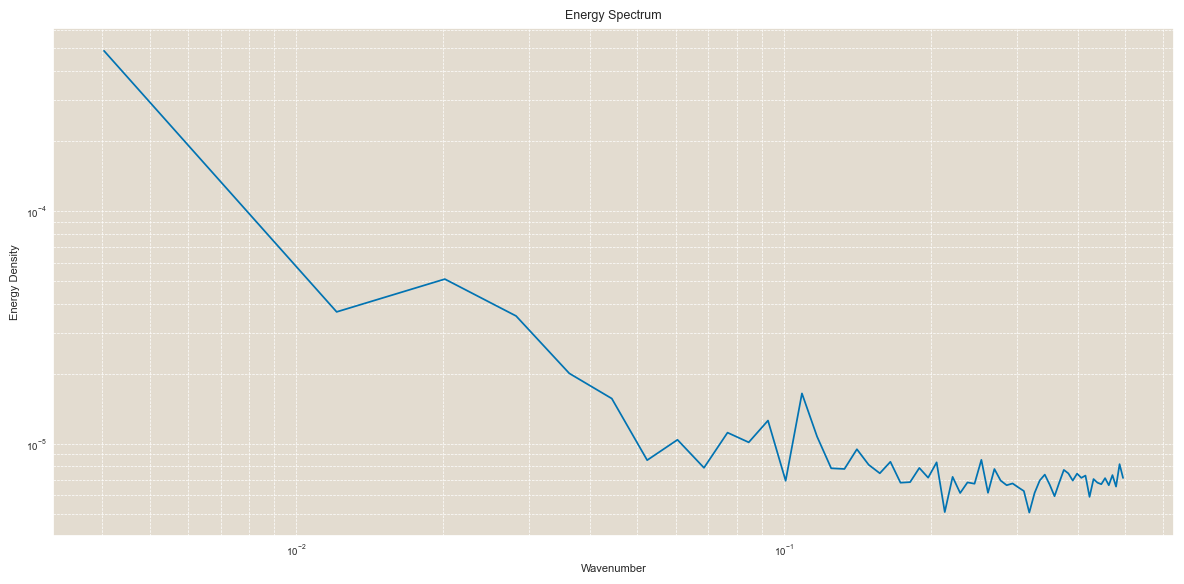

In [5]:
v_ft = np.fft.fftshift(np.fft.fft2(v))

# Compute the radial energy spectrum (averaging over circular shells in k-space)
kx = np.fft.fftshift(np.fft.fftfreq(v.shape[0]))
ky = np.fft.fftshift(np.fft.fftfreq(v.shape[1]))
kx, ky = np.meshgrid(kx, ky)
k = np.sqrt(kx**2 + ky**2)

# Define the bins for k (radial wavenumbers)
k_bins = np.linspace(0, 0.5, v.shape[0]//2)
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])

E_u = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(v_ft)**2).ravel())[0]

# Plotting the average energy spectrum
plt.figure(figsize=(12, 6))
plt.loglog(k_bin_centers, E_u)
plt.xlabel('Wavenumber')
plt.ylabel('Energy Density')
plt.title('Energy Spectrum')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


### Spatial Autocorrelation Function:

The spatial autocorrelation function quantifies how similar the velocities are across different spatial lags in the vector field. If we have a velocity vector field defined as $\mathbf{v}(x,y)$, where $\mathbf{v}$ is the velocity at position $(x,y)$, the spatial autocorrelation function $R(\Delta x, \Delta y)$ for spatial lags $\Delta x$ and $\Delta y$ is given by:

$$
R(\Delta x, \Delta y) = \sum_{x,y} \mathbf{v}(x,y) \cdot \mathbf{v}(x + \Delta x, y + \Delta y)
$$

This function computes the dot product of velocity vectors at the original and shifted positions, thus incorporating both the magnitude and direction of the velocities into the correlation.

### Wiener-Khinchin Theorem for Spatial Data:

The Wiener-Khinchin theorem states that the Fourier transform of the autocorrelation function of a stationary process is equal to the power spectral density (PSD) of that process. For spatial data, this relationship allows us to compute the PSD of the velocity field from the spatial autocorrelation function, and vice versa. The theorem for spatial data is expressed as:

$$
S(\mathbf{k}) = \mathcal{F}\{ R(\Delta x, \Delta y) \}
$$

where $S(\mathbf{k})$ represents the spatial power spectral density as a function of the spatial frequency vector $\mathbf{k}$, and $\mathcal{F}$ denotes the Fourier transform.

Conversely, we can obtain the spatial autocorrelation function from the PSD using the inverse Fourier transform:

$$
R(\Delta x, \Delta y) = \mathcal{F}^{-1}\{ S(\mathbf{k}) \}
$$

### Computing the Spatial Autocorrelation Function:

To compute the spatial autocorrelation function for a single frame of PIV data:

1. **Calculate the Velocity Magnitude**: First, compute the magnitude of the velocity vector at each point in the 2D space.

$$
\text{magnitude} = \sqrt{u^2 + v^2}
$$

where $u$ and $v$ are the $x$ and $y$ components of the velocity vector, respectively.

2. **Compute the 2D Fourier Transform**: Then, apply a 2D Fourier transform to the magnitude of the velocity vectors to move from the spatial domain to the frequency domain.

$$
F(\mathbf{k}) = \mathcal{F}\{ \text{magnitude} \}
$$

3. **Calculate the Power Spectral Density**: Multiply the Fourier-transformed velocity magnitude by its complex conjugate to get the power spectral density.

$$
S(\mathbf{k}) = F(\mathbf{k}) \cdot F^*(\mathbf{k})
$$

4. **Inverse Fourier Transform**: Finally, apply the inverse 2D Fourier transform to the PSD to obtain the spatial autocorrelation function.

$$
R(\Delta x, \Delta y) = \mathcal{F}^{-1}\{ S(\mathbf{k}) \}
$$

This spatial autocorrelation function will describe how velocity magnitudes are correlated with themselves over spatial shifts in the PIV data. It helps to identify patterns and coherent structures within the flow. For example, here we can visualize the spatial autocorrelation of the entire first frame.

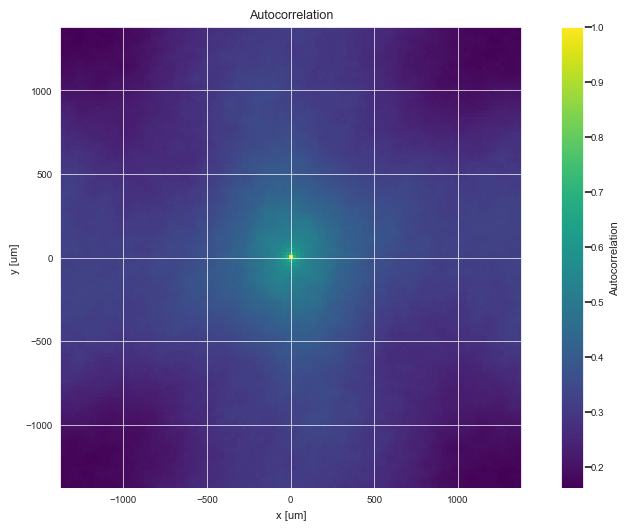

In [6]:
# Calculate the autocorrelation function with fourier transform
full_product = np.fft.fft2(v) * np.conj(np.fft.fft2(v))

# get the real part of the inverse fourier transform (autocorrlation function)
inverse = np.real(np.fft.ifft2(full_product))

# normalize the autocorrelation function
normalized_inverse = inverse / inverse[0, 0]

# shift the autocorrelation function so that the center is at the center of the image
shifted_inverse =  np.fft.fftshift(normalized_inverse)

# plot inverse fourier transform of the product of the fourier transform of the magnitude of the velocity
plt.figure(figsize=(10, 6))  # Set the figure size
im = plt.imshow(shifted_inverse, cmap='viridis', origin='lower', extent=[-2762/2, 2762/2, -2762/2, 2762/2])
plt.xlabel('x [um]')
plt.ylabel('y [um]')
cbar = plt.colorbar(im)
cbar.set_label('Autocorrelation')
plt.title('Autocorrelation')
plt.show()


Here we compute the spatial autocorrelation with a space lag $r$ as follows:

$$
\frac{\text{{inverse}}[r, r] + \text{{inverse}}[-r, -r]}{\text{{shape}}[0] \times \text{{shape}}[1]}
$$

Notice that the maximum number of time lags $r$ are 127 because we have that number of points per axis.

In [7]:
# Define the number of r values
r_values = 60

# Initialize an array to store the autocorrelation results
results = np.zeros(r_values)

# Compute the autocorrelation for each r value
for r in range(r_values):
    # Compute the autocorrelation value for the current r value
    autocorrelation_value = (inverse[r, r] + inverse[-r, -r]) / (v.shape[0] * v.shape[1])
    # Store the autocorrelation value in the results array
    results[r] = autocorrelation_value

# Normalize the results array
results = results / results[0]

From the spatial correlation function, a correlation length is discerned, representing the extent over which two points retain significant correlation. This length is derived from the velocity autocorrelation, $A_{\text{vel}}(r,\tau)$, fitted to an exponential decay model:
$$
A_{\text{vel}}(r,\tau) = Ae^{-\frac{\tau}{B}} + C.
$$
The correlation length, symbolized by $\lambda(\tau)$, is then given by:
$$
\lambda(\tau) = -B \times \log \left( \frac{0.3-C}{A} \right).
$$
Temporal averages of this length, represented by $\langle \lambda(\tau) \rangle$, furnish an overarching correlation length for the entire experimental dataset.


In [8]:
# Define the exponential decay model
def exponential_decay(tau, A, B, C):
    return A * np.exp(-tau/B) + C

# Fit the results to the exponential decay model
params, _ = curve_fit(exponential_decay, np.arange(len(results)), results, maxfev=5000)
A, B, C = params
fitted_values = exponential_decay(np.arange(r_values), A, B, C)

# Compute the correlation length
lambda_tau = -B * np.log((0.3 - C) / A) 
print(f"The correlation length is {lambda_tau}")

The correlation length is 22.892403220776846


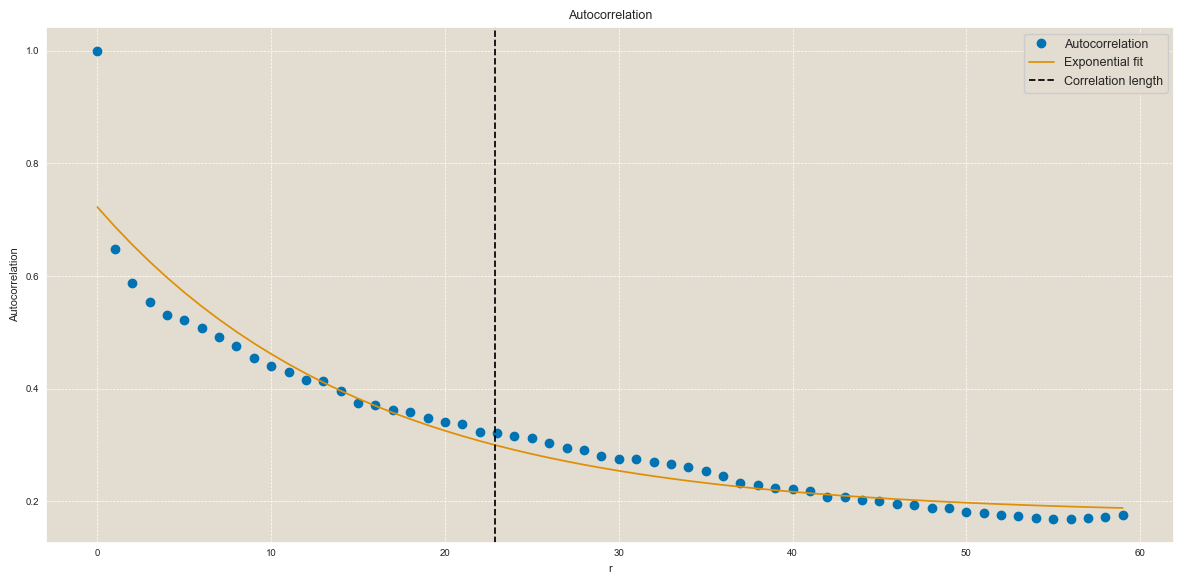

In [9]:
x = np.arange(len(results)) 

# Plot the autocorrelation function
plt.figure(figsize=(12, 6))
plt.plot(x, results, 'o', label='Autocorrelation')
plt.plot(fitted_values, label='Exponential fit')
plt.axvline(lambda_tau, color='black', linestyle='--', label='Correlation length')
plt.xlabel('r')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [14]:
# Corrected resolution
pixels_per_micron = 0.73

# Original image size in pixels
original_dimensions_pixels = 2048

# PIV grid size in vectors
piv_grid_size = 127

# Calculate resolution in microns per pixel
microns_per_pixel = 1 / pixels_per_micron

# Calculate the total physical size of the original image in microns
original_width_microns = original_dimensions_pixels * microns_per_pixel

# Calculate the new inter-vector distance in microns
# We subtract one from the grid size because we are calculating the distance between the centers of the vectors
inter_vector_distance_microns = original_width_microns / (piv_grid_size - 1)

inter_vector_distance_microns


22.265709936942812